### Setup

In [1]:
if '__file__' in globals():
    import os, sys
#     sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
    sys.path.append(os.path.join(os.path.dirname(os.path.abspath('__file__')), '..'))
import numpy as np
from dezero import Variable
import dezero.functions as F

In [2]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
y = x + c
print(y)

variable([[11 22 33]
          [44 55 66]])


In [3]:
# x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
# c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
# t = x + c
# y = F.sum(t)

# y.backward(retain_grad=True)
# print(y.grad)
# print(t.grad)
# print(x.grad)
# print(c.grad)

In [4]:
# x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
# y = F.reshape(x, (6,))
# y.backward(retain_grad=True)
# print(x.grad)

## ステップ40 ブロードキャストを行う関数

### 40.1 broadcast_to 関数とsum_to 関数
まずは、NumPy のnp.broadcast_to(x, shape) について見ていきましょう。

In [5]:
x = np.array([1, 2, 3])
y = np.broadcast_to(x, (2, 3))
print(y)

[[1 2 3]
 [1 2 3]]


上記のように、元は(3,) の形状の1 次元配列で、要素がコピーされて(2, 3) の
形状になります。それでは、ブロードキャスト（つまりは、「要素のコピー」）を行っ
た場合、その逆伝播はどうなるでしょうか。

「要素のコピー」を行った場合、逆伝播では勾配の「和」を求めます。np.broadcast_to のような関数の場合は、図40-1 のようになります。

![40_1](fig/40_1.png)

図40-1 のとおり、broadcast_to 関数の逆伝播は、入力x の形状になるように勾配の和を求めます。それには、sum_to(x, shape) という関数があればシンプルに解決できます。sum_to 関数は、x の要素の和を求めてshape の形状にします。そのような関数があれば、図40-1 のように、順伝播と逆伝播の関係が作られます。sum_to(x, shape) 関数は、x の要素の和を求めてshape の形状にする関数
です。しかし、そのような関数はNumPy にはありません。そこでDeZero ではdezero/utils.py に、NumPy 版のsum_to 関数を用意しています。その関数を使えば、次のような計算を行うことができます。

In [6]:
import numpy as np
from dezero.utils import sum_to
x = np.array([[1, 2, 3], [4, 5, 6]])
y = sum_to(x, (1, 3))
print(f'1×3 :\n {y}\n')

y = sum_to(x, (2, 1))
print(f'2×1 :\n {y}')

1×3 :
 [[5 7 9]]

2×1 :
 [[ 6]
 [15]]


上記のように、sum_to(x, shape) 関数は、shape の形状になるように和を取り
ます。できることはnp.sum 関数と同じですが、引数の与え方が異なります。

続いて、sum_to 関数の逆伝播について考えます。sum_to(x, shape) は、x の
要素の和を求めてshape の形状にします。その逆伝播には、図40-2 のように、
broadcast_to 関数がそのまま利用できます。

![40_2](fig/40_2.png)

図40-2 のように、sum_to 関数の逆伝播はbroadcast_to 関数を使って、入力x
の形状になるように勾配の要素を複製します。以上が、NumPy 版のbroadcast_to
関数とsum_to 関数についてです。それでは続いて、DeZero 版のbroadcast_to
関数とsum_to 関数を実装します

### 40.2 DeZero のbroadcast_to とsum_to 関数

まずは、DeZero のBroadcastTo クラスとbroadcast_to 関数を次に示します。

``` python
class BroadcastTo(Function):
    def __init__(self, shape):
        self.shape = shape
    def forward(self, x):
        self.x_shape = x.shape
        y = np.broadcast_to(x, self.shape)
        return y
    def backward(self, gy):
        gx = sum_to(gy, self.x_shape)
        return gx

def broadcast_to(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return BroadcastTo(shape)(x)
```

ここでは、逆伝播のコードに注目しましょう。逆伝播では、入力x の形状になるよ
うに、DeZero のsum_to 関数を利用しています。そのsum_to 関数は、これから実
装します。それでは続いて、SumTo クラスとsum_to 関数を示します

```python
class SumTo(Function):
    def __init__(self, shape):
        self.shape = shape

    def forward(self, x):
        self.x_shape = x.shape
        y = utils.sum_to(x, self.shape)
        return y

    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape)
        return gx


def sum_to(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return SumTo(shape)(x)
```

ここでも注目すべきは、逆伝播のコードです。逆伝播では、入力x の形状になるよ
うに、勾配の要素を複製します。それを行うにあたって、先ほど実装したDeZero の
broadcast_to 関数を使用します。そのように、broadcast_to 関数とsum_to 関
数は、相互に依存し合う関係になっています。以上で、DeZero 版のbroadcast_to
関数とsum_to 関数は完成です。

### 40.3 ブロードキャストへの対応

本ステップでsum_to という関数を実装したのには、1 つ理由があります。それは、NumPy のブロードキャストに対応するためです。ブロードキャストとは、形状の異なる多次元配列どうしの演算を可能にするNumPy の機能です。例として、次のコードを見てみましょう

In [7]:
x0 = np.array([1, 2, 3])
x1 = np.array([10])
y = x0 + x1
print(y)

[11 12 13]


ここで、x0 とx1 の形状は異なります。この計算が行われるとき、x1 がx0 の形状
に合うように要素がコピーされます。ここで重要な点は、NumPy のブロードキャス
トという機能は、私たちの見えないところで行われるということです。そして、この
ブロードキャストは、私たちのDeZero においても行われます。たとえば、次の例を
見てみましょう。

In [8]:
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

variable([11 12 13])


上記のように、順伝播では、ndarray インスタンスに対しての実装を行っているた
め、ブロードキャストが発生します。もちろん、順伝播でブロードキャストが行われ
た場合、その逆伝播では、ブロードキャストの逆伝播が行われなければなりません。
しかし、現状のDeZero では、ブロードキャストの逆伝播は何も行われていません。
NumPy のブロードキャストは、broadcast_to 関数で行われます。そして、
broadcast_to 関数の逆伝播は、sum_to 関数に対応します。その点を考慮すれば、
DeZero のAdd クラスは、次のように修正できます。

```python
class Add(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape
        y = x0 + x1
        return y

    def backward(self, gy):
        gx0, gx1 = gy, gy
        if self.x0_shape != self.x1_shape:  # for broadcaset
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gx0, gx1
```

順伝播のときにブロードキャストが発生していれば、入力時のx0 とx1 の形状が
異なっているはずです。その場合は、ブロードキャスト用の逆伝播の計算を行いま
す。それには、勾配gx0 はx0 の形状になるように和を求めます。同様に、勾配gx1
はx1 の形状になるように和を求めます。
上の修正は、dezero/core.py にあるAdd クラスに行います。同様に、Mul、Sub、
Div クラスなど、四則演算に対応するクラスにはすべて、同じ修正を施します。これ
で、ブロードキャストへの対応ができました。以上の修正によって、次のコードを書
くことができます。

In [9]:
import numpy as np
from dezero import Variable
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)
y.backward()
print(x0.grad)
print(x1.grad)

variable([11 12 13])
variable([1 1 1])
variable([3])


上の例では、x0 + x1 においてブロードキャストが発生しています。しかし今回
は、そのブロードキャストの逆伝播がDeZero の関数として正しく行われています。
実際、x1 の勾配は3 と正しい結果です。以上で、DeZero はブロードキャストにも対
応できました。

## ステップ41 行列の積

本ステップのテーマは、「ベクトルの内積」と「行列の積」です。まずはその2 つの
計算方法を示し、それをDeZeroの関数として実装します。本ステップが終われば、
テンソルを扱う最低限の関数は出揃います。そうすれば、いよいよ実践的な問題を解くことができます

### 41.1 ベクトルの内積と行列の積

それでは、「ベクトルの内積」と「行列の積」について説明します。まずは、ベ
クトルの内積について説明します。ここでは2 つのベクトル$a = (a_1, · · · , a_n)$ と
$b = (b_1, · · · , b_n)$ があることを仮定します。このときベクトルの内積は、式(41.1)
のように定義されます。

$ab = a_1b_1 + a_2b_2 + · · · + a_nb_n$　　　　(41.1)

式(41.1) のとおり、2 つのベクトル間の対応する要素の積を足し合わせたものがベ
クトルの内積です。

続いて「行列の積」です。行列の積は、図41-1 の手順に従って計算します。

![41_1](fig/41_1.png)

図41-1 のとおり、行列の積では、左側の行列の「横方向に並ぶベクトル」と右側
の行列の「縦方向に並ぶベクトル」の間で内積が計算されます。そして、その結果が
新しい行列の対応する要素に格納されます。たとえば、a の1 行目とb の1 列目の
結果は1 行1 列目の要素へ、a の2 行目とb の1 列目は2 行1 列目の要素へ、... と
なります。
それでは、ベクトルの内積と行列の積をNumPy を使って実装してみます。それ
には、np.dot 関数が利用できます。

In [10]:
import numpy as np
# ベクトルの内積
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.dot(a, b)
print(c)

# 行列の積
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
c = np.dot(a,b)
print(c)

32
[[19 22]
 [43 50]]


ここで示したように、ベクトルの内積と行列の積の計算には、ともにnp.dot 関数
が使えます。np.dot(x, y) の引数が2 つとも1 次元配列の場合はベクトルの内積を計算し、引数が2 次元配列の場合は行列の積を計算します。

### 41.2 行列の形状チェック

行列やベクトルを使った計算においては、その「形状」に注意を払うことが重要です。たとえば、行列の積の計算では、図41-2 のように形状が推移します。

![41_2](fig/41_2.png)

図41-2 の例では、3 × 2 の行列a と2 × 4 の行列b の積によって、3 × 4 の行列c
が生成されます。このとき、図が示すように、行列a とb の対応する次元（軸）の
要素数は一致させる必要があります。そして、結果となる行列c は、行列a の行数と
行列b の列数から構成されます。

行列の積などの計算では、行列の形状に注目し、その推移を見ていくことが重要です。本書では、そのような形状に注目した確認作業を「形状チェック」と呼ぶことにします。

#### 行列の積の逆伝播

続いて、行列の積の逆伝播について説明します。行列の積の逆伝播は、やや複雑に
なるため、ここでは正攻法的な説明を行い、その後で直感的な理解が得られる説明を
行います。ちなみに、行列の積の計算は、DeZero ではMatMul クラスとmatmul 関
数として実装します。matmul とは「matrix multiply」の略です。
さて、行列の積の逆伝播を説明するにあたり、y = xW という計算を考えます。
ここで、x、W、y の形状は、それぞれ1 × D、D × H、1 × H とします。このと
き、計算グラフは図41-3 のようになります。

![41_3](fig/41_3.png)

繰り返しになりますが、私たちは、最終的にスカラを出力する計算を扱います。そのため、ここでは最終的にLというスカラを出力する計算を考えます（このLの各変数に関する微分を、逆伝播で求めます）。このとき、x のi 番目の要素に関する微分$\frac{\partial L}{\partial x_i}$は、次のように求められます。

$\frac{\partial L}{\partial x_i} = \sum_{j}\frac{\partial L}{\partial y_j}\frac{\partial y_j}{\partial x_i} \hspace{10mm}$ 
(41.2)

式(41.2) の$\frac{\partial L}{\partial x_i}$は、$x_i$を（少しだけ）変化させたときに、L がどれだけ変化するかという「変化の割合」を表します。ここで$x_i$ を変化させたときには、ベクトルyのすべての要素も変化します。そして、y の各要素の変化を通じて、最終的にL が変化することになります。そのため、$x_i$ からL に至るチェインルールの経路は複数あり、その総和が$\frac{\partial L}{\partial x_i}$となります。
さて式(41.2) ですが、これはまだ簡単にできます。それには、$\frac{\partial L}{\partial x_i}= W_{ij}$が成り立つことを利用します。それを式(41.2) に代入すれば、次の式(41.3) が導けます。

$\frac{\partial L}{\partial x_i} = \sum_{j}\frac{\partial L}{\partial y_j}\frac{\partial y_j}{\partial x_i}= \sum_{j}\frac{\partial L}{\partial y_j}W_{ij} \hspace{10mm}$ 
(41.3)

式(41.3) から、$\frac{\partial L}{\partial x_i}$
は、「ベクトル$\frac{\partial L}{\partial y}$」と「Wのi 行目のベクトル」の内積に
よって求められることが分かります。この関係から、次の式が導けます。

$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial y}W^T \hspace{10mm}
$
(41.4)

式(41.4) が示すように、$\frac{\partial L}{\partial x}$は行列の積によって一度に求められます。このとき、行列（とベクトル）の形状に注目すると、図41-4 のようになります。

![41_4](fig/41_4.png)

図41-4 を見ると、行列の「形状チェック」をクリアしていることが分かります。
これによって、式(41.4) は行列の計算として成立することが確認できます。また、
その逆手を取って――つまり、その整合性が成り立つようにして――、逆伝播の数
式（実装）を導出することも考えられます†2。その方法を説明するにあたって、再度
y = xW という行列の積の計算を考えます。ただし今度は、x の形状は、N × D で
あるとします。つまり、x、W、y の形状はそれぞれN ×D、D ×H、N ×H とし
ます。このとき、逆伝播の計算グラフは図41-5 のようになります。

![41_5](fig/41_5.png)

それでは$\frac{\partial L}{\partial x}$と$\frac{\partial L}{\partial W}$を導出しましょう。行列の形状に注目し、その整合性が保たれ
るように行列の積を組み立てることにします。そうすると、図41-6 の式が導けます。

![41_6](fig/41_6.png)

図41-6 の式は、図41-4 の式と同じように、各行列の要素を計算して両辺を比較す
れば導けます。また、行列の積の形状チェックも満たしていることを確認できます。
この数式があれば、DeZero の関数として「行列の積」を実装することは簡単です。
それは次のように実装できます。

```python

class MatMul(Function):
    def forward(self, x, W):
        y = x.dot(W)
        return y

    def backward(self, gy):
        x, W = self.inputs
        gx = matmul(gy, W.T)
        gW = matmul(x.T, gy)
        return gx, gW


def matmul(x, W):
    return MatMul()(x, W)

```

逆伝播では、図41-6 の数式に従い、それをDeZero の関数としてコーディングし
ます。なお、順伝播ではnp.dot(x, W) の代わりに、x.dot(W) として実装しまし
た。そのように、ndarray インスタンスのメソッドとしても利用できます。

上のコードの逆伝播で使用するmatmul 関数は、今まさに実装している関数で
す。また、転置を行う操作（W.T とx.T）では、DeZero のtranspose 関
数が呼ばれます（それはステップ38 で実装しました）。

これで、次のようにDeZero のmatmul 関数を使って計算できます。そして、微分
も求めることができます。

In [11]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.random.randn(2, 3))
w = Variable(np.random.randn(3, 4))
y = F.matmul(x, w)
y.backward()

# print(x.grad)
# print(w.grad)
print(x.grad.shape)
print(w.grad.shape)

(2, 3)
(3, 4)


ここでは、NumPy の多次元配列をランダムに生成し、それを使って計算を行って
います。上のコードは、エラーなく実行できます。また、x.grad.shape とx.shape
が等しいこと、そして、w.grad.shape とW.shape が等しいことが確認できます。
以上でDeZero 版の行列の積は完成です。

## ステップ42 線形回帰

機械学習は「データ」を使って問題を解きます。人が問題の解決法を考えるのでは
なく、集められた「データ」から問題の解決法をコンピュータに見つけさせます（学習させます）。このように、「データ」から解法を見つけることが機械学習の本質です。これから私たちは、DeZero を使って機械学習の問題に挑みます。ここでは、機械学習の中で最も基本となる「線形回帰」を実装します。

### 42.1 トイ・データセット

本ステップでは、実験用に小さなデータセットを作ります。そのような小さなデー
タセットは「トイ・データセット」と呼ばれます。ここでは再現性を考慮して、次の
ように、乱数のシードを固定してデータを生成します。

In [12]:
import numpy as np
np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)

上記のように、x とy の2 つの変数からなるデータセットを作ります。このとき、
点群は直線上にあり、y にはノイズとして乱数が加算されています。この(x, y) の
点をプロットすると、図42-1 のようになります。

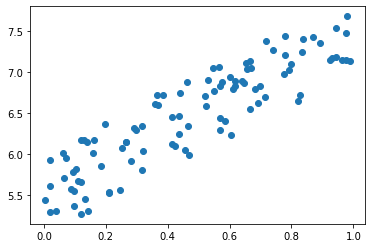

In [13]:
import matplotlib.pyplot as plt
plt.scatter(x,y)

図42-1 のように、x とy は「線形」の関係にありますが、そこにはノイズが含まれています。私たちの目標は、x の値からy の値を予測できるモデル（数式）を作ることです。

実数値であるy を、x の値から予測することは「回帰（regression）」と呼ば
れます。さらに、その予測するモデルを「線形」として（直線として）予測する
とき、それは「線形回帰」と呼ばれます。

### 42.2 線形回帰の理論

これからの目標は、与えられたデータに適合するような関数を見つけることです。
ここでは、y とx の関係は線形であることを仮定しているため、y = Wx + b とい
う式で表せます（ここでW はスカラとします）。このy = Wx + b という直線は、
図42-2 のように表されます。

![42_2](fig/42_2.png)

図42-2 のとおり、私たちの目標は、データに合うような直線y = Wx + b を見つ
けることです。そのためには、データと予測値の差――これを「残差（residual）」と
呼びます――をできるかぎり減らすことが求められます。ここでは、私たちの予測値
（モデル）とデータとの誤差を表す指標を、次の式で定義します。

$ L = \frac{1}{N}\sum_{i=1}^{N}(f(x_i)-y_i)^2 \hspace{10mm}$ 
(42.1)

式(42.1) では、全部でN 個の点があるとして、$(x_i, y_i)$ の各点において2 乗誤差
を求め、それらを足し合わせます。そして、その平均を求めるために$\frac{1}{N}$ を掛けます。
この式は、平均2 乗誤差（mean squared error）と呼ばれます。なお、式(42.1) では、$\frac{1}{N}$ ... としましたが、$\frac{1}{2N}$ ... と定義するケースもあります。ただし、どちらの場合であっても、勾配降下法で解く場合は学習率の値を調整することで同じ問題設定にな
ります。

モデルの“悪さ” を評価する関数は、損失関数（loss function）と呼ばれます。
そのため、線形回帰は「損失関数として平均2 乗誤差を用いる」と表現できます。

私たちの目標は、式(42.1) で表される損失関数の出力を最小化するWとbを見つけることです。これは関数の最適化に関する問題です。そして、私たちはすでに（ステップ28で）、そのような問題を勾配降下法を使って解いてきました。ここでも、勾配降下法を使って式(42.1) を最小化するパラメータを見つけます。

### 42.3 線形回帰の実装

それでは、DeZero を使って線形回帰を実装します。ここでは、コードを前半と後
半の2 つのパートに分けて掲載します。まずは前半のコードを示します。

In [14]:
# Generate toy dataset
np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)
x, y = Variable(x), Variable(y)

W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

def predict(x):
    y = F.matmul(x, W) + b
    return y

また、上のコードではpredict 関数を定義します。そこでは、行列の積のmatmul
関数を使って計算を行います。行列の積を使うことで、複数のデータ（上の例では
100 個のデータ）に対して、まとめて計算を行うことができます。このときの形状の
推移は、図42-3 のようになります。

![42_3](fig/42_3.png)

図42-3 のように、対応する次元の要素数が一致していることが分かります。そし
て、結果となるy の形状は(100, 1) になります。つまり、100 個のデータを持つx
について、すべてのデータそれぞれに対してW の掛け算が行われたことになります。
これで、一度の計算で、すべてのデータの予測値が求められます。なお、ここではx
のデータの次元は1 ですが、これがD の場合は、W の形状を(D, 1) とすれば、正し
い計算が行えます。たとえばD=4 の場合、図42-4 のように行列の積の計算が行われ
ます。

![42_4](fig/42_4.png)

図42-4 のように、x.shape[1] とW.shape[0] を一致させることで、行列の積の
計算が正しく行われます。このとき、100個のデータそれぞれに対して、W による
「ベクトルの内積」の計算が行われます。

In [15]:
# if '__file__' in globals():
#     import os, sys
# #     sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
#     sys.path.append(os.path.join(os.path.dirname(os.path.abspath('__file__')), '..'))
# import numpy as np
# from dezero import Variable
# import dezero.functions as F


variable([[0.64433458]]) variable([1.29473389]) variable(42.296340129442335)
variable([[1.12672345]]) variable([2.26959351]) variable(23.97380754378544)
variable([[1.48734571]]) variable([3.00386712]) variable(13.609686745040522)
variable([[1.75641886]]) variable([3.557186]) variable(7.747049961219976)
variable([[1.95666851]]) variable([3.97439789]) variable(4.43057410592155)
variable([[2.10518573]]) variable([4.28923203]) variable(2.554280381353593)
variable([[2.21482401]]) variable([4.52705574]) variable(1.492599869047195)
variable([[2.29524981]]) variable([4.70694745]) variable(0.8916952181756939)
variable([[2.35373273]]) variable([4.84325585]) variable(0.5514270962227455)
variable([[2.39573972]]) variable([4.9467725]) variable(0.3585915308319281)
variable([[2.425382]]) variable([5.02561369]) variable(0.24915731977561134)
variable([[2.44575118]]) variable([5.08588371]) variable(0.1869065876539789)
variable([[2.45917205]]) variable([5.13217364]) variable(0.1513533629631488)
variable(

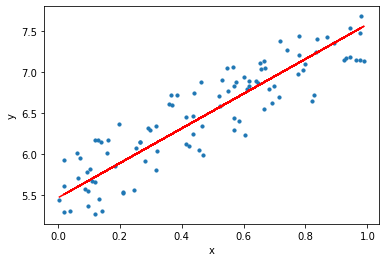

In [16]:
import matplotlib.pyplot as plt

def mean_squared_error(x0, x1):
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)


lr = 0.1
iters = 100

for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    # Update .data attribute (No need grads when updating params)
    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data
    print(W, b, loss)

    
plt.scatter(x.data, y.data, s=10)
plt.xlabel('x')
plt.ylabel('y')
y_pred = predict(x)
plt.plot(x.data, y_pred.data, color='r')
plt.show()

ここでは、平均2 乗誤差を求める関数をmean_squared_error(x0, x1) と
して実装します。それは式(42.1) を、DeZero の関数を使って実装するだけで
す。その次に、勾配降下法によってパラメータを更新します。その実装はすで
にステップ28 で行いました。ここでの注意点は、パラメータを更新するときは、
W.data -= lr * W.grad.data のように、インスタンス変数のdata に対して計
算を行うことです。パラメータの更新は、単にデータを更新するだけなので、計算グ
ラフを作る必要はありません。
それでは、上のコードを実行してみましょう。そうすると、損失関数の出力
値が減っていくことが分かります。そして最終的には、W = [[2.11807369]]、
b = [5.46608905] という値が得られます。参考までに、このパラメータによって
得られる直線のグラフは図42-5 のようになります。

図42-5 のとおり、データにフィット（適合）したモデルを得ることができました。
私たちは、DeZero を使って正しく線形回帰を実装できたのです！ これで線形回帰
の実装は終了です。最後に、DeZero のmean_squared_error 関数について補足し
ます。

### 42.4 【補足】DeZero のmean_squared_error 関数

先ほど私たちは、平均2 乗誤差を求める関数を実装しました。そのコードを抜粋す
ると、次のようになります。

```python
def mean_squared_error(x0, x1):
    diff = x0 - x1
    y = F.sum(diff ** 2) / len(diff)
    return y
```

この関数は正しい計算を行います。そして、DeZero の関数を使って計算している
ので、微分も求めることができます。しかし、この実装方式には改良点があります。
それを説明するにあたって、図42-6 の計算グラフを見てみましょう。

![42_6](fig/42_6.png)

図42-6 は、上のmean_squared_error 関数によって作られる計算グラフです。
ここで注目してほしい点は、途中にある変数です。そこには無名の変数が3 つ存在し
ます。それらは計算グラフに記録されているため、計算グラフが存在する間はメモリ
に生き続けます。そして、それらの変数のデータ（ndarray インスタンス）も同様に
生き続けます。

DeZero で微分を求めるには、順伝播を行い、その後に逆伝播を行います。
図42-6 に存在する変数たち（そして、その変数が参照するデータたち）は、順
伝播と逆伝播の間中はメモリ上に存在し続けることになります。

ここでメモリの使用量に問題がない場合は、上の実装方式で問題ありません。ただ
し、第3 者に使ってもらう関数としては、より良い実装方式が考えられます。それ
は、Function クラスを継承して実装する方式です。つまりは、MeanSquaredErrorというDeZero の関数クラスを実装するのです。実際のコードを示すと、次のように
なります。

```python
class MeanSquaredError(Function):
    def forward(self, x0, x1):
        diff = x0 - x1
        y = (diff ** 2).sum() / len(diff)
        return y

    def backward(self, gy):
        x0, x1 = self.inputs
        diff = x0 - x1
        gx0 = gy * diff * (2. / len(diff))
        gx1 = -gx0
        return gx0, gx1


def mean_squared_error(x0, x1):
    return MeanSquaredError()(x0, x1)
```

まずは順伝播でndarray インスタンスに対して実装を行います。そのコードは、
先ほどDeZero 版の関数で実装したコードとほとんど同じです。この処理単位をひと
まとめにして、その逆伝播のコードをbackward に実装します。逆伝播の実装は、数
式で微分を求めて、それをコーディングします。ここでは、その説明は省略します。
この新しい実装方式によるmean_squared_error 関数も、旧式のそれと同じ結
果が得られます。ただし、メモリ効率の良い実装になります。なぜなら、新しい
mean_squared_error 関数では、図42-7 のような計算グラフが作られるからです。

![42_7](fig/42_7.png)

が計算グラフに存在しません。その途中のデータは、MeanSquaredError クラスの
forward メソッドの中でのみ使用されます。より正確に言うと、それらはndarray
インスタンスとして使用され、forward メソッドのスコープを抜けるとすぐにメモ
リから消去されるのです。
以上の理由から、dezero/functions.py にあるmean_squared_error 関
数は、新しい方式で実装されています。旧式版の実装は、参考のために、
mean_squared_error_simple という名前で―― 最後に_simple という名前
を付けて―― 、dezero/functions.py に追加しています。以上がDeZero の
mean_squared_error 関数についての補足です。